In [1]:
import json
import csv
import pickle
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('ggplot')
#plt.rcParams["figure.figsize"] = (20,3)
from tqdm import tqdm

from scipy.spatial.distance import cdist, euclidean
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric
import torch_geometric.utils
from torch_geometric.utils import from_networkx, negative_sampling


In [2]:
data_path = './scidocs/data/'
paper_cite_file = data_path + 'paper_metadata_view_cite_read.json'
paper_cls_file = data_path + 'paper_metadata_mag_mesh.json'
paper_rec_file = data_path + 'paper_metadata_recomm.json'
user_activity_and_citations_embeddings_path = data_path + 'specter-embeddings/user-citation.jsonl'

## Look at the data

In [3]:
papers_data = {}
with open(paper_cite_file, 'r') as f:
    papers_data = json.load(f)

In [4]:
list(list(papers_data.values())[0].keys())

['abstract', 'authors', 'cited_by', 'paper_id', 'references', 'title', 'year']

In [5]:
papers_data = {}
with open(paper_rec_file, 'r') as f:
    papers_data = json.load(f)

In [6]:
list(list(papers_data.values())[0].keys())

['abstract', 'authors', 'cited_by', 'paper_id', 'references', 'title', 'year']

In [7]:
papers_df = pd.DataFrame(papers_data).T

In [8]:
#extra column
all(papers_df.index == papers_df.paper_id)

True

In [9]:
papers_df.head(5)

,abstract,authors,cited_by,paper_id,references,title,year
0002c0f45b3ef0f1491f91cbfefe9543e9af6163,In this paper we introduce an hp certified red...,"[3122778, 39921175, 1905947, 2848614]","[16728d6f0a225bb8a71ebe4d0acd2512ca775327, 48d...",0002c0f45b3ef0f1491f91cbfefe9543e9af6163,"[07e1f620f68c0be579fb05bf6d231fa06b0db7c3, 7f2...",An hp Certified Reduced Basis Method for Param...,2011
0004d38aa501306e2719e4d0413dcb5c788676b1,We test whether momentum strategies remain pro...,[],"[67d88e58812562f0270b7077408776157a542fbf, 946...",0004d38aa501306e2719e4d0413dcb5c788676b1,"[18cb63580217983f2fd4b54141b2f83b96819dd3, 360...",Are Momentum Profits Robust to Trading Costs,2003
000587e08c6ce8c3d4c74360e34abe7c543a0e98,OBJECTIVES\nThe death of a child in the pediat...,"[4526222, 6110925, 38791518, 3743376, 31914233...","[55bac4ab517f5174d3259e7631d4fc6fa58cbac7, 593...",000587e08c6ce8c3d4c74360e34abe7c543a0e98,"[95f677c6287e19a9afb8c25848b6f3437340e17a, ecb...","""I was able to still be her mom""--parenting at...",2012
0006a1983fc6a346dee3f07c33711094221b781e,While most reversible data hiding in encrypted...,"[3243117, 35593499, 36521450, 38682132]","[af36ca9a7710240bd90ed04afc10b1d0542ac9a8, ffb...",0006a1983fc6a346dee3f07c33711094221b781e,"[5745307212d66ae8dcd70cdd04e6d8f2ea6781a5, 881...",Block cipher based separable reversible data h...,2015
000823feb2af6580d0767306aa946e6abef9ebf6,"In this paper, we describe an approach for min...","[1726249, 1789756, 1681236]","[b3cecbd8e0e0561bcee4b0c511b4e26909bfa69b, 80e...",000823feb2af6580d0767306aa946e6abef9ebf6,"[2b50094ee714e95e6d545f2f94006d4e7d325f2c, 15d...",World-scale mining of objects and events from ...,2008


## Create graph

In [10]:
G = nx.DiGraph()
G.add_nodes_from(papers_data.keys())

In [11]:
for paper_id, paper_attrs in papers_data.items():
    for citing_id in paper_attrs['cited_by']:
        if citing_id in G:
            G.add_edge(citing_id, paper_id)
    for cited_id in paper_attrs['references']:
        if cited_id in G:
            G.add_edge(paper_id, cited_id)

In [12]:
len(G)

36261

# Find the most connected node and create a subgraph from the nodes connected to it

## Find the nodes degrees

In [13]:
conn_comp_sizes = []
for c in nx.weakly_connected_components(G):
    conn_comp_sizes.append(len(c))

In [14]:
sum(sorted(conn_comp_sizes, reverse=True))/len(conn_comp_sizes)

1.6041141340411413

In [15]:
sorted(conn_comp_sizes, reverse=True)[int(len(conn_comp_sizes)/2)]

1

In [16]:
sorted(conn_comp_sizes, reverse=True)[:20]

[4716,
 187,
 111,
 97,
 93,
 84,
 61,
 56,
 55,
 46,
 45,
 39,
 39,
 33,
 30,
 27,
 27,
 27,
 26,
 26]

## Create a dictionary where key is the degree of the node and value is nodes connected to it

In [17]:
conn_comps = {len(c):c for c in nx.weakly_connected_components(G)}

## Get the node with the biggest degree (most connected one) 

In [18]:
largest_conn_comp = conn_comps[max(conn_comps.keys())]

In [19]:
len(largest_conn_comp)

4716

In [20]:
for count, node_id in enumerate(largest_conn_comp):
    print(node_id)
    if count > 4:
        break

5d2f4b1070b28d29525ec47746d2524e40373842
00925792469dbb39b4e0300121de0846d2b0c733
2c7f71ac14bc15e596d1e61afecb145cee556f61
2a1f354db64bb03bbe000905a89c1933e5cad831
3f01d7657b55edd5e5591e5458fb34f742b581c5
1cd2cc88c3f816d12aa77d1ed7655768ba3dd305


## Create a subgraph from the nodes connected to it

In [21]:
Glcc = G.subgraph(largest_conn_comp)

In [22]:
len(Glcc)

4716

In [23]:
#combine previous cells into functions
def get_graph(file_name):
    papers_data = {}
    with open(file_name, 'r') as f:
        papers_data = json.loads(f.read())
    G = nx.DiGraph()
    G.add_nodes_from(papers_data.keys())
    for paper_id, paper_attrs in papers_data.items():
        for citing_id in paper_attrs['cited_by']:
            if citing_id in G:
                G.add_edge(citing_id, paper_id)
        for cited_id in paper_attrs['references']:
            if cited_id in G:
                G.add_edge(paper_id, cited_id)
    return G

def get_LCC(G):
    conn_comps = {len(c):c for c in nx.weakly_connected_components(G)}
    largest_conn_comp = conn_comps[max(conn_comps.keys())]
    Glcc = G.subgraph(largest_conn_comp)
    return Glcc.copy()

In [24]:
G = get_graph(paper_rec_file)
G = get_LCC(G)

In [25]:
len(G)

4716

# Add embedding as a node attribute

## Download embeddings

In [26]:
def load_embeddings_from_jsonl(embeddings_path, G):
    embeddings = {}
    with open(embeddings_path, 'r') as f:
        for line in tqdm(f, desc='reading embeddings from file...'):
            line_json = json.loads(line)
            if line_json['paper_id'] in G:
                embeddings[line_json['paper_id']] = np.array(line_json['embedding'], dtype=np.float32)
    return embeddings

def load_embeddings_from_json(embeddings_path, G):
    embs = {}
    with open(embeddings_path, 'r') as f:
        all_embs = json.load(f)
        for id, emb in tqdm(all_embs.items(), desc='reading embeddings from file...'):
            if id in G.nodes:
                embs[id] = np.array(emb, dtype=np.float32)
    return embs

#embeddings = load_embeddings_from_jsonl(user_activity_and_citations_embeddings_path, G)
embeddings = load_embeddings_from_json('papers_embeddings_sp1.json', G)

reading embeddings from file...: 100%|██████████| 4716/4716 [00:00<00:00, 19548.65it/s]


## Amount of resourses with embeddings

In [27]:
len(embeddings.keys())

4716

## Create a subgraph based on resourses with embs

In [28]:
Grec = get_LCC(G.subgraph(embeddings.keys()))
nx.set_node_attributes(Grec, {node_id: {"x":embedding} for node_id, embedding in embeddings.items()})

In [29]:
len(Grec), len(Grec.edges), len(embeddings)

(4716, 7264, 4716)

# Updload the final graph

In [30]:
with open(data_path + 'rec_graph_new.pkl', 'wb') as f:
    pickle.dump(Grec, f)

# Link prediction

## Create LinkPredictionModel class

In [31]:
class LinkPredictionModel(torch.nn.Module):

    def __init__(self, layer_type, sz_in, num_layers=2, sz_hid=128, sz_out=64):
        super().__init__()

        # GNN layers with ReLU
        encoder = []
        encoder.append(layer_type(sz_in, sz_hid))
        encoder.append(nn.ReLU())
        for _ in range(num_layers-2):
            encoder.append(layer_type(sz_hid, sz_hid))
            encoder.append(nn.ReLU())
        encoder.append(layer_type(sz_hid, sz_out))
        self.encoder = nn.ModuleList(encoder)
        #self.H = None # torch.tensor(sz_in, sz_out)
    
    # Encoding: usual GNN propagation
    def encode(self, fts, adj):
        for l in self.encoder:
            if isinstance(l, nn.ReLU):
                fts = l(fts)
            else:
                fts = l(fts, adj)
            #self.H = fts
        return fts
    
    # Decoding: dot(H[i], H[j]) for each edge in edge_index
    # Larger dot => the model is more confident that this edge should exist
    def decode(self, H, edge_index):
        return (H[edge_index[0]] * H[edge_index[1]]).sum(dim=1)

## Train validation test split

In [32]:
from torch_geometric.utils import train_test_split_edges

def train_val_test_split(G, val_ratio, test_ratio):
    data = from_networkx(G)
    data.train_mask = data.val_mask = data.test_mask = data.y = None
    data = train_test_split_edges(data, val_ratio, test_ratio)
    return data


data = train_val_test_split(Grec, 0.1, 0.1)
print(data.x)
print(data)
print()
print(f'Train set: {data.train_pos_edge_index.shape[1]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {data.val_pos_edge_index.shape[1]} positive edges, {data.val_neg_edge_index.shape[1]} negative edges')
print(f'Test set: {data.test_pos_edge_index.shape[1]} positive edges, {data.test_neg_edge_index.shape[1]} negative edges')

e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)
e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


tensor([[-7.1683e-01,  5.8859e-03,  1.4497e+00,  ...,  2.7113e-01,
         -4.2628e-01,  8.5092e-01],
        [ 2.8212e-01,  7.6820e-01, -5.7797e-01,  ..., -4.9640e-01,
          7.8802e-01, -6.6096e-04],
        [-1.3116e+00,  5.6536e-01,  7.9595e-01,  ...,  9.4639e-02,
          5.7759e-02,  7.6619e-01],
        ...,
        [-5.5096e-01,  1.2957e+00,  1.1367e-01,  ...,  3.5197e-01,
         -5.2934e-01, -2.9195e-01],
        [-3.1284e-02,  1.4400e-01, -3.6099e-01,  ...,  2.7814e-01,
          6.7189e-01,  5.9333e-01],
        [-5.5228e-01,  3.6068e-01,  2.4199e-01,  ..., -3.2730e-02,
          1.1154e+00,  6.5860e-01]])
Data(x=[4716, 768], val_pos_edge_index=[2, 365], test_pos_edge_index=[2, 365], train_pos_edge_index=[2, 5840], train_neg_adj_mask=[4716, 4716], val_neg_edge_index=[2, 365], test_neg_edge_index=[2, 365])

Train set: 5840 positive edges, we will sample the same number of negative edges at runtime
Val set: 365 positive edges, 365 negative edges
Test set: 365 positive e

## Utility functions

In [33]:
# A utility function to compute the ROC-AUC score on given edges
def get_roc_auc(model, H, edge_index, labels):
    with torch.no_grad():
        #H = model.encode(data.x, data.train_pos_edge_index)
        z = model.decode(H, edge_index)
        s = z.sigmoid()
        return roc_auc_score(labels, s)
    
# A utility function to compute the F1-score on given edges
def get_f1_score(model, H, edge_index, labels):
    with torch.no_grad():
        z = model.decode(H, edge_index)
        s = z.sigmoid().numpy() >= 0.5
        return f1_score(labels, s)
    
# A utility function to compute the confusion matrix on given edges
def get_confusion_matrix(model, H, edge_index, labels):
    with torch.no_grad():
        z = model.decode(H, edge_index)
        s = z.sigmoid().numpy() >= 0.5
        return confusion_matrix(labels, s) 
    

# A utility function to plot all metrics
def plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 2, figure=fig)

    # create sub plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    ax4 = fig.add_subplot(gs[2, :])
    
    # Plot loss for 10 epochs
    ax1.set_title('Loss 10 epoch')
    ax1.plot(np.arange(10)+1, loss_all[:10])
    ax1.set_xlabel('Epoch')
    
    # Plot loss for remaining epochs
    ax2.set_title('Loss after 10 epochs')
    ax2.plot(np.arange(10, num_epochs)+1, loss_all[10:])
    ax2.set_xlabel('Epoch')
    
    # Plot ROC AUC for remaining epochs
    ax3.set_title('ROC AUC Scores')
    ax3.plot(np.arange(num_epochs)+1, auc_val_all, label='ROC Validation', alpha=0.8)
    ax3.plot(np.arange(num_epochs)+1, auc_test_all, label='ROC Test', alpha=0.8)
    ax3.set_xlabel('Epoch')
    ax3.legend()

    # Plot ROC AUC for remaining epochs
    ax4.set_title('F1-Scores')
    ax4.plot(np.arange(num_epochs)+1, f1_val_all, label='F1 Validation', alpha=0.8)
    ax4.plot(np.arange(num_epochs)+1, f1_test_all, label='F1 Test', alpha=0.8)
    ax4.set_xlabel('Epoch')
    ax4.legend()

    fig.tight_layout()


def display_cms(cm_val, cm_test, title1, title2, figsize=(5,3)):
    f, axes = plt.subplots(1,2, figsize=figsize)

    axes[0].set_title(title1, fontsize=10)
    axes[0].grid(False)
    ConfusionMatrixDisplay(cm_val).plot(colorbar=False, ax=axes[0])

    axes[1].set_title(title2, fontsize=10)
    axes[1].grid(False)
    ConfusionMatrixDisplay(cm_test).plot(colorbar=False, ax=axes[1])

    f.tight_layout()
    plt.show()


def get_binary_metrics(model, H, auc_all: list, f1_all: list, edge_index, labels):
    auc = get_roc_auc(model, H, edge_index, labels)
    f1 = get_f1_score(model, H, edge_index, labels)
    cm = get_confusion_matrix(model, H, edge_index, labels)
    auc_all.append(auc)
    f1_all.append(f1)

    return auc, f1, cm

## Define training function

In [34]:
def train(model, data, num_epochs, test=True, verbose=True, plot=True):
    """
    Trains a given model on a given dataset for a specified number of epochs, evaluating
    performance metrics on validation and test sets.

    Parameters:
      model (LinkPredictionModel): The model to be trained.
      data (torch_geometric.data.data.Data): The dataset containing training, validation, and test data.
      num_epochs (int): The number of epochs to train the model.
      test (bool): Whether to evaluate the model on the test dataset.
      verbose (bool): Whether to print detailed progress messages.
      plot (bool): Whether to plot performance metrics and confusion matrices.

    Returns:
      H: The final node representations learned by the model.
    """

    # Initialize containers for storing performance metrics over epochs
    loss_all = []
    auc_val_all = []
    auc_test_all = []
    f1_val_all = []
    f1_test_all = []
    
    # Set up the loss function and optimizer for binary classification
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare validation and test data: positive and negative edge indices and labels
    val_pos, val_neg = data.val_pos_edge_index, data.val_neg_edge_index
    val_edge_index = torch.cat([val_pos, val_neg], dim=1)
    val_labels = torch.cat([torch.ones(val_pos.shape[1]), torch.zeros(val_neg.shape[1])])
    
    test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
    test_edge_index = torch.cat([test_pos, test_neg], dim=1)
    test_labels = torch.cat([torch.ones(test_pos.shape[1]), torch.zeros(test_neg.shape[1])])

    # Track the best F1 score on validation data
    f1_val_best = -1

    for epoch in range(num_epochs):
        # Sample negative edges for training
        pos_edge_index = data.train_pos_edge_index
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edge_index.shape[1]
        )
    
        # Zero gradients, encode graph data, and decode to get scores for edges
        optimizer.zero_grad()
        H = model.encode(data.x, pos_edge_index)
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        z = model.decode(H, edge_index)

        # Compute loss and backpropagate
        labels = torch.cat([torch.ones(pos_edge_index.shape[1]),
                            torch.zeros(neg_edge_index.shape[1])])
        loss = loss_fn(z, labels)
        loss.backward()
        optimizer.step()
        
        if test:
            # Evaluate model on validation and test sets, update metrics
            auc_val, f1_val, cm_val = get_binary_metrics(model, H, val_edge_index, val_labels)
            auc_test, f1_test, cm_test = get_binary_metrics(model, H, test_edge_index, test_labels)
            loss_all.append(loss.item())  # Convert loss to Python float and store
            
            if verbose and (epoch+1) % 100 == 0:
                # Print metrics every 100 epochs
                print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.4f} | AUC Val: {auc_val:.3f} | AUC Test: {auc_test:.3f}')
                print(f'                                    | F1 Val: {f1_val:.3f} | F1 Test: {f1_test:.3f}')
                if plot:
                    # Optionally plot confusion matrices
                    display_cms(cm_val, cm_test, title1=f'Epoch {epoch+1} Validation CM', title2=f'Epoch {epoch+1} Test CM')

            # Update best metrics if current F1 score on validation is the highest
            if f1_val > f1_val_best:
                f1_val_best, auc_val_best, cm_val_best = f1_val, auc_val, cm_val
                f1_test_best, auc_test_best, cm_test_best, epoch_best, loss_best = f1_test, auc_test, cm_test, epoch+1, loss

    if test and verbose:
        # Print best overall metrics after training
        print(f'\nBest Epoch: {epoch_best} | Loss: {loss_best:.4f} | AUC Val: {auc_val_best:.3f} | AUC Test: {auc_test_best:.3f}')
        print(f'                          | F1 Val: {f1_val_best:.3f} | F1 Test: {f1_test_best:.3f}')

    if test and plot:
        # Plot best confusion matrices and performance metrics over epochs
        display_cms(cm_val_best, cm_test_best, title1='Best Validation CM', title2='Best Test CM')
        plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all)
    
    return H


## Model training

### 2-layer GCN, hidden=128, output=64

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 128)
    (1): ReLU()
    (2): GCNConv(128, 64)
  )
)
[Epoch 1/100] Loss: 15.201858520508 | AUC Val: 0.866 | AUC Test: 0.884
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 6.187529563904 | AUC Val: 0.948 | AUC Test: 0.952
                                    | F1 Val : 0.676 | F1 Test: 0.677

[Epoch 3/100] Loss: 2.379033803940 | AUC Val: 0.959 | AUC Test: 0.958
                                    | F1 Val : 0.709 | F1 Test: 0.705

[Epoch 10/100] Loss: 0.854049324989 | AUC Val: 0.944 | AUC Test: 0.947
                                    | F1 Val : 0.713 | F1 Test: 0.715

[Epoch 11/100] Loss: 0.736308932304 | AUC Val: 0.944 | AUC Test: 0.946
                                    | F1 Val : 0.717 | F1 Test: 0.724

[Epoch 12/100] Loss: 0.648963332176 | AUC Val: 0.943 | AUC Test: 0.944
                                    | F1 Val : 0.721 | F1 Test: 0.727

[Epoch 13/100] Loss: 0.598812

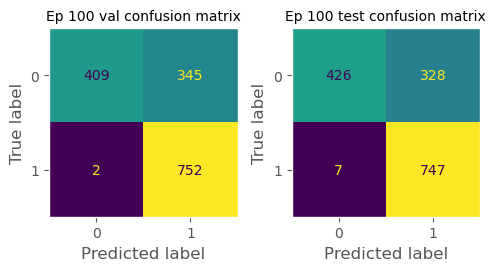


The best epoch: 76 Loss: 0.421203762293 | AUC Val: 0.958 | AUC Test: 0.964
                                         | F1 Val : 0.815 | F1 Test: 0.816


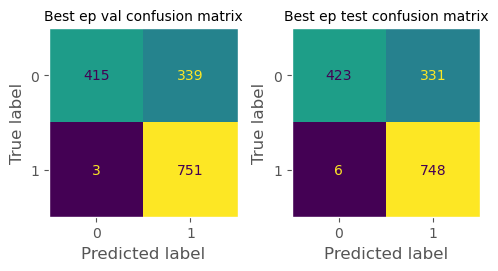

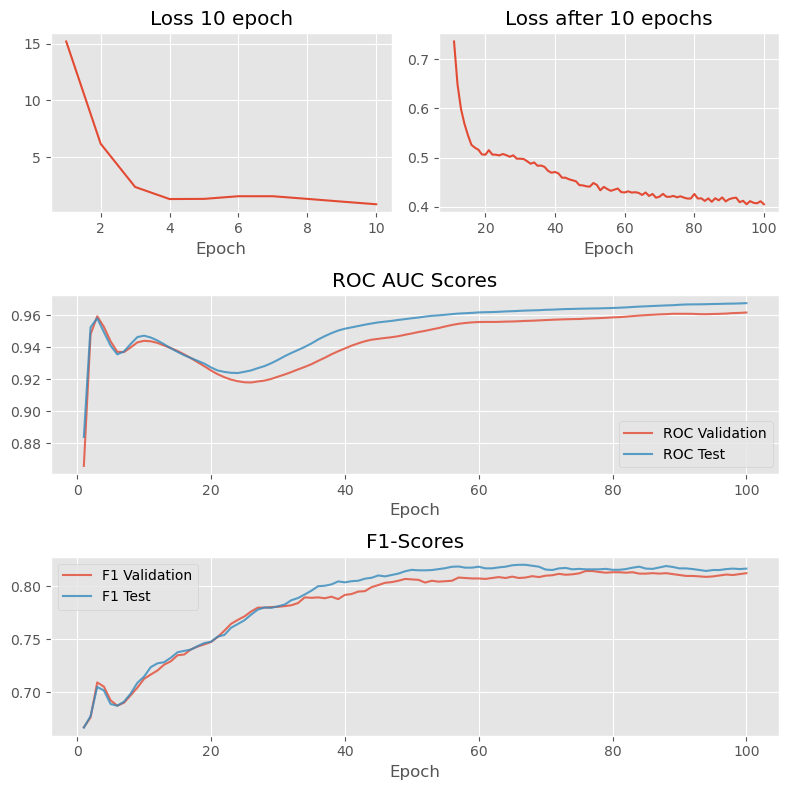

In [43]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv, data.x.shape[1])
print(model)
train(model, data, num_epochs=100)  #  AUC Val: 0.871 | AUC Test: 0.818 | F1 Val : 0.756 | F1 Test: 0.741
                            # new embs AUC Val : 0.962 | AUC Test: 0.967 | F1 Val : 0.813 | F1 Test: 0.817

### 2-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 26.685287475586 | AUC Val: 0.770 | AUC Test: 0.793
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 8.217954635620 | AUC Val: 0.966 | AUC Test: 0.964
                                    | F1 Val : 0.674 | F1 Test: 0.672

[Epoch 3/100] Loss: 3.565386772156 | AUC Val: 0.960 | AUC Test: 0.958
                                    | F1 Val : 0.676 | F1 Test: 0.676

[Epoch 5/100] Loss: 3.358650207520 | AUC Val: 0.964 | AUC Test: 0.964
                                    | F1 Val : 0.678 | F1 Test: 0.683

[Epoch 6/100] Loss: 2.827809810638 | AUC Val: 0.971 | AUC Test: 0.969
                                    | F1 Val : 0.687 | F1 Test: 0.692

[Epoch 7/100] Loss: 2.174519777298 | AUC Val: 0.974 | AUC Test: 0.972
                                    | F1 Val : 0.698 | F1 Test: 0.702

[Epoch 8/100] Loss: 1.606934666

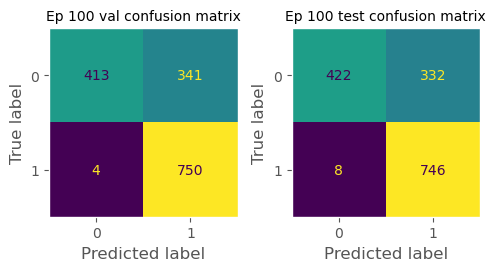


The best epoch: 77 Loss: 0.406963944435 | AUC Val: 0.968 | AUC Test: 0.969
                                         | F1 Val : 0.814 | F1 Test: 0.810


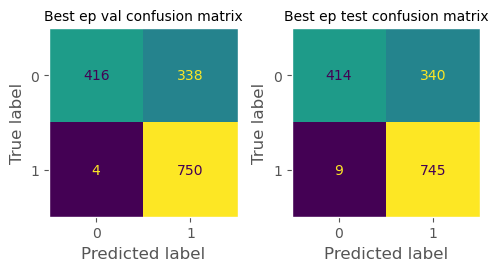

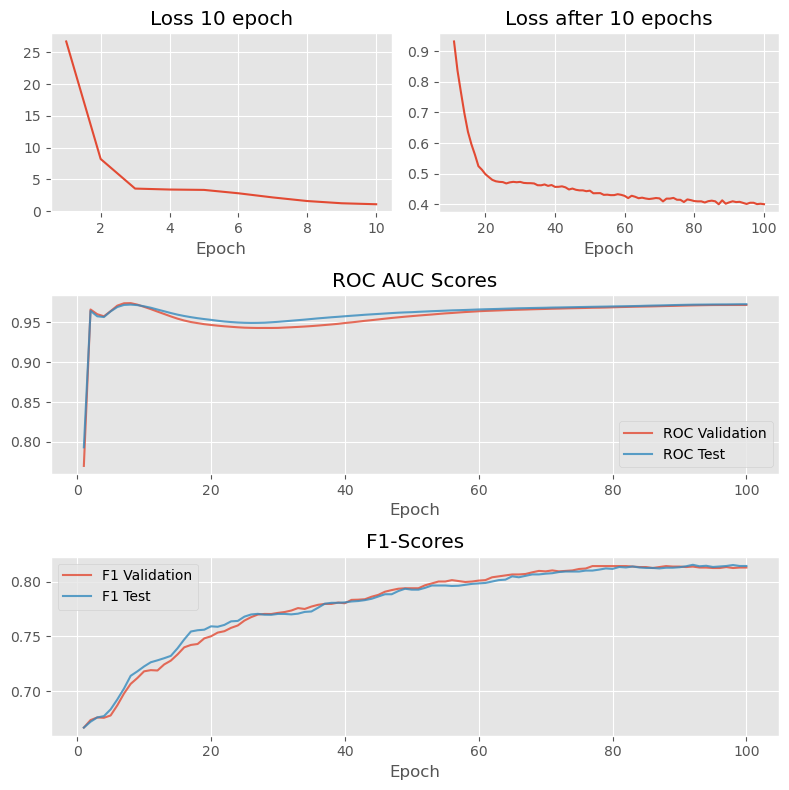

In [44]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100)   # AUC Val : 0.803 | AUC Test: 0.750 | F1 Val : 0.759 | F1 Test: 0.702
                            # new embs AUC Val : 0.972 | AUC Test: 0.973 | F1 Val : 0.813 | F1 Test: 0.814

### 3-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 11.354269981384 | AUC Val: 0.560 | AUC Test: 0.587
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 3/100] Loss: 1.365459322929 | AUC Val: 0.957 | AUC Test: 0.944
                                    | F1 Val : 0.670 | F1 Test: 0.669

[Epoch 4/100] Loss: 1.086392879486 | AUC Val: 0.951 | AUC Test: 0.942
                                    | F1 Val : 0.672 | F1 Test: 0.671

[Epoch 5/100] Loss: 0.856000244617 | AUC Val: 0.953 | AUC Test: 0.948
                                    | F1 Val : 0.683 | F1 Test: 0.675

[Epoch 6/100] Loss: 0.703703105450 | AUC Val: 0.957 | AUC Test: 0.956
                                    | F1 Val : 0.686 | F1 Test: 0.682

[Epoch 7/100] Loss: 0.602752089500 | AUC Val: 0.961 | AUC Test: 0.962
                                    | F1 Val : 0.694 | F1 T

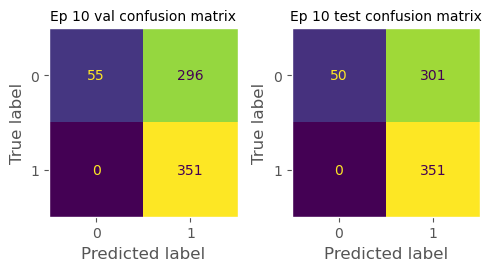

[Epoch 11/100] Loss: 0.520188033581 | AUC Val: 0.967 | AUC Test: 0.960
                                    | F1 Val : 0.706 | F1 Test: 0.699

[Epoch 12/100] Loss: 0.518524646759 | AUC Val: 0.967 | AUC Test: 0.959
                                    | F1 Val : 0.711 | F1 Test: 0.701

[Epoch 13/100] Loss: 0.513417840004 | AUC Val: 0.967 | AUC Test: 0.959
                                    | F1 Val : 0.711 | F1 Test: 0.705

[Epoch 14/100] Loss: 0.513107955456 | AUC Val: 0.966 | AUC Test: 0.959
                                    | F1 Val : 0.718 | F1 Test: 0.711

[Epoch 15/100] Loss: 0.511985838413 | AUC Val: 0.966 | AUC Test: 0.960
                                    | F1 Val : 0.721 | F1 Test: 0.720

[Epoch 16/100] Loss: 0.505868554115 | AUC Val: 0.966 | AUC Test: 0.961
                                    | F1 Val : 0.727 | F1 Test: 0.724

[Epoch 17/100] Loss: 0.505180239677 | AUC Val: 0.965 | AUC Test: 0.961
                                    | F1 Val : 0.737 | F1 Test: 0.727

[Epoch

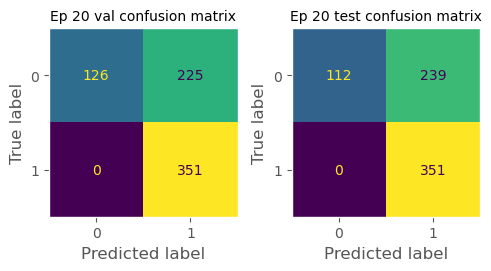

[Epoch 20/100] Loss: 0.495966076851 | AUC Val: 0.965 | AUC Test: 0.962
                                    | F1 Val : 0.757 | F1 Test: 0.746

[Epoch 21/100] Loss: 0.491251319647 | AUC Val: 0.966 | AUC Test: 0.963
                                    | F1 Val : 0.759 | F1 Test: 0.749

[Epoch 22/100] Loss: 0.487758010626 | AUC Val: 0.966 | AUC Test: 0.963
                                    | F1 Val : 0.761 | F1 Test: 0.753

[Epoch 23/100] Loss: 0.485145419836 | AUC Val: 0.967 | AUC Test: 0.963
                                    | F1 Val : 0.768 | F1 Test: 0.755

[Epoch 24/100] Loss: 0.479930639267 | AUC Val: 0.967 | AUC Test: 0.963
                                    | F1 Val : 0.773 | F1 Test: 0.760

[Epoch 25/100] Loss: 0.474486798048 | AUC Val: 0.967 | AUC Test: 0.964
                                    | F1 Val : 0.779 | F1 Test: 0.766

[Epoch 26/100] Loss: 0.466795355082 | AUC Val: 0.967 | AUC Test: 0.964
                                    | F1 Val : 0.787 | F1 Test: 0.774

[Epoch

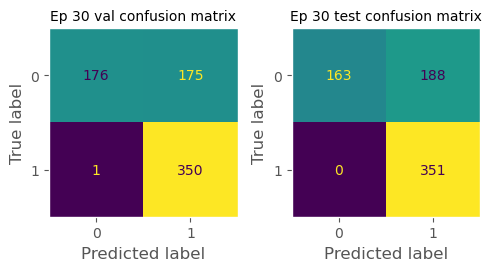

[Epoch 30/100] Loss: 0.447009533644 | AUC Val: 0.968 | AUC Test: 0.967
                                    | F1 Val : 0.799 | F1 Test: 0.789

[Epoch 31/100] Loss: 0.443794995546 | AUC Val: 0.968 | AUC Test: 0.968
                                    | F1 Val : 0.806 | F1 Test: 0.793

[Epoch 32/100] Loss: 0.448554426432 | AUC Val: 0.968 | AUC Test: 0.969
                                    | F1 Val : 0.807 | F1 Test: 0.799

[Epoch 34/100] Loss: 0.433974236250 | AUC Val: 0.969 | AUC Test: 0.971
                                    | F1 Val : 0.809 | F1 Test: 0.811

[Epoch 35/100] Loss: 0.438679426908 | AUC Val: 0.969 | AUC Test: 0.972
                                    | F1 Val : 0.813 | F1 Test: 0.809

[Epoch 36/100] Loss: 0.429068684578 | AUC Val: 0.969 | AUC Test: 0.973
                                    | F1 Val : 0.814 | F1 Test: 0.809

[Epoch 37/100] Loss: 0.425508290529 | AUC Val: 0.970 | AUC Test: 0.975
                                    | F1 Val : 0.815 | F1 Test: 0.808

[Epoch

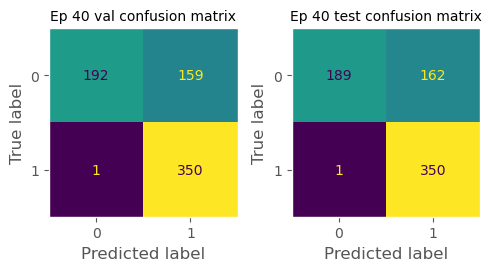

[Epoch 42/100] Loss: 0.415724396706 | AUC Val: 0.972 | AUC Test: 0.978
                                    | F1 Val : 0.817 | F1 Test: 0.813

[Epoch 43/100] Loss: 0.418090224266 | AUC Val: 0.973 | AUC Test: 0.978
                                    | F1 Val : 0.819 | F1 Test: 0.812

[Epoch 50/100] Loss: 0.406359732151 | AUC Val : 0.975 | AUC Test: 0.980
                                    | F1 Val : 0.820 | F1 Test: 0.814



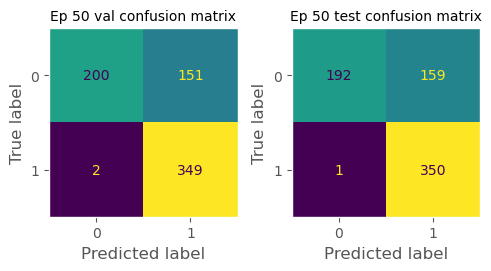

[Epoch 50/100] Loss: 0.406359732151 | AUC Val: 0.975 | AUC Test: 0.980
                                    | F1 Val : 0.820 | F1 Test: 0.814

[Epoch 51/100] Loss: 0.415483206511 | AUC Val: 0.975 | AUC Test: 0.980
                                    | F1 Val : 0.821 | F1 Test: 0.816

[Epoch 52/100] Loss: 0.407345503569 | AUC Val: 0.975 | AUC Test: 0.980
                                    | F1 Val : 0.822 | F1 Test: 0.818

[Epoch 57/100] Loss: 0.401126593351 | AUC Val: 0.977 | AUC Test: 0.980
                                    | F1 Val : 0.823 | F1 Test: 0.815

[Epoch 60/100] Loss: 0.403550922871 | AUC Val : 0.977 | AUC Test: 0.980
                                    | F1 Val : 0.823 | F1 Test: 0.811



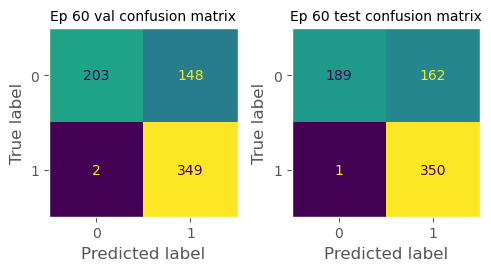

[Epoch 70/100] Loss: 0.397807091475 | AUC Val : 0.979 | AUC Test: 0.979
                                    | F1 Val : 0.822 | F1 Test: 0.809



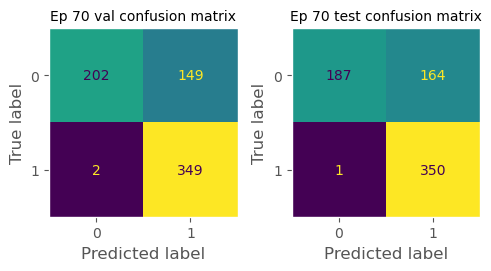

[Epoch 80/100] Loss: 0.400599300861 | AUC Val : 0.979 | AUC Test: 0.979
                                    | F1 Val : 0.823 | F1 Test: 0.814



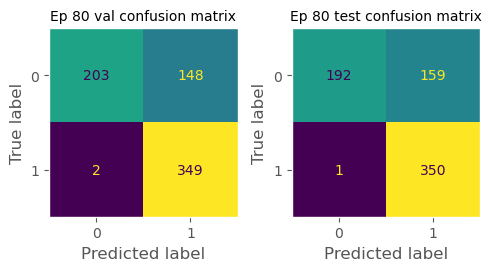

[Epoch 90/100] Loss: 0.394153922796 | AUC Val : 0.980 | AUC Test: 0.979
                                    | F1 Val : 0.823 | F1 Test: 0.808



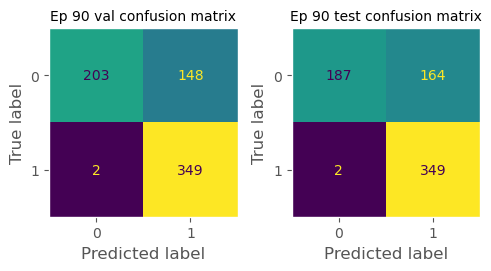

[Epoch 100/100] Loss: 0.395609945059 | AUC Val : 0.981 | AUC Test: 0.979
                                    | F1 Val : 0.817 | F1 Test: 0.809



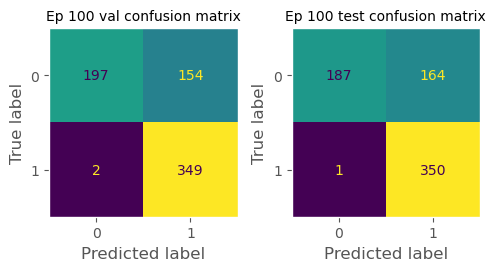


The best epoch: 57 Loss: 0.401126593351 | AUC Val: 0.977 | AUC Test: 0.980
                                         | F1 Val : 0.823 | F1 Test: 0.815


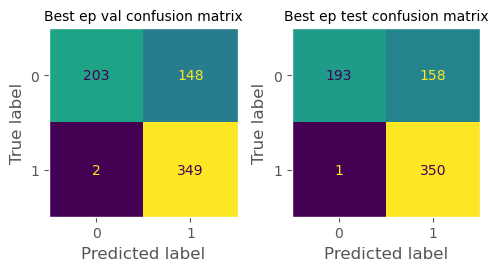

tensor([[ 0.0362,  0.1417,  0.2142,  ..., -0.2500, -0.0324,  0.0094],
        [ 0.3446, -0.0271, -0.0731,  ..., -0.0969, -0.4918, -0.0603],
        [ 0.1865,  0.0645, -0.1940,  ..., -0.2350,  0.1823,  0.3600],
        ...,
        [-0.1704,  0.2114, -0.2110,  ...,  0.0659, -0.1030, -0.1858],
        [ 0.1532,  0.0350,  0.0703,  ..., -0.1171, -0.1171,  0.0252],
        [-0.0484,  0.0147, -0.2214,  ..., -0.1223, -0.0564,  0.1170]],
       grad_fn=<AddBackward0>)

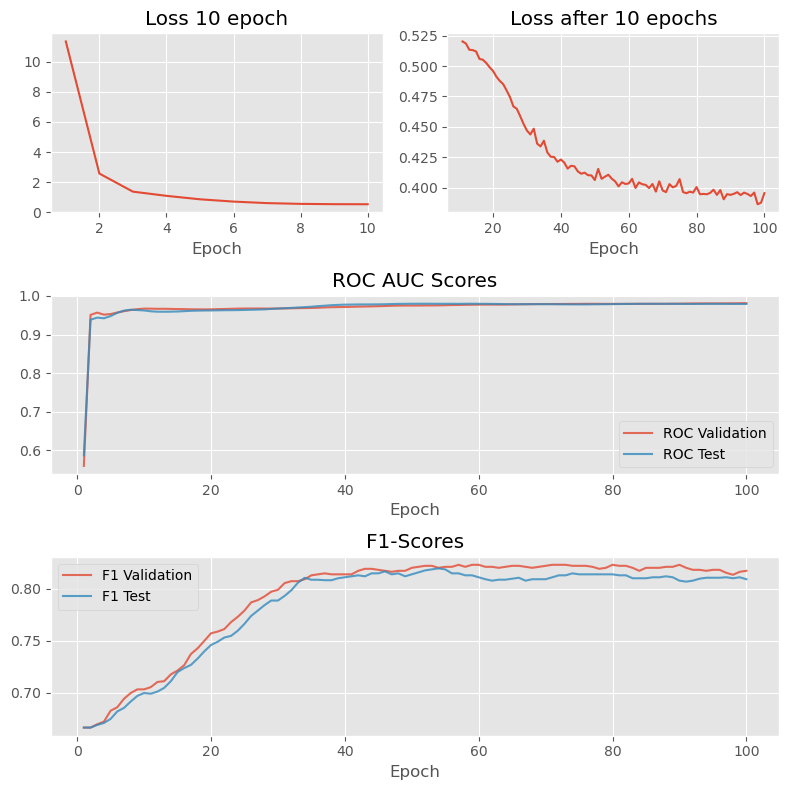

In [35]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=3,
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100)  #      AUC Val: 0.929 | AUC Test: 0.875 | F1 Val : 0.712 | F1 Test: 0.692
                                # new embs AUC Val: 0.977 | AUC Test: 0.976 | F1 Val : 0.823 | F1 Test: 0.825

### 4-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 256)
    (5): ReLU()
    (6): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 5.403267860413 | AUC Val: 0.892 | AUC Test: 0.901
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 1.010666251183 | AUC Val: 0.895 | AUC Test: 0.899
                                    | F1 Val : 0.669 | F1 Test: 0.668

[Epoch 6/100] Loss: 0.590926527977 | AUC Val: 0.936 | AUC Test: 0.939
                                    | F1 Val : 0.672 | F1 Test: 0.673

[Epoch 7/100] Loss: 0.577483832836 | AUC Val: 0.941 | AUC Test: 0.946
                                    | F1 Val : 0.677 | F1 Test: 0.677

[Epoch 8/100] Loss: 0.571569263935 | AUC Val: 0.945 | AUC Test: 0.950
                                    | F1 Val : 0.682 | F1 Test: 0.681

[Epoch 9/100] Loss: 0.565376639366 | AUC Val: 0.947 | AUC Test: 0.953
                 

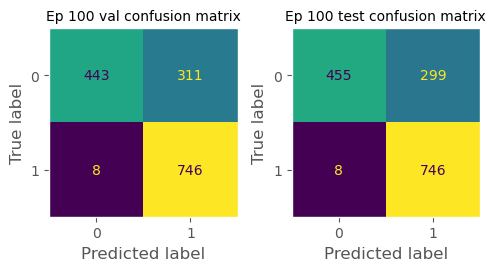


The best epoch: 42 Loss: 0.404166936874 | AUC Val: 0.974 | AUC Test: 0.974
                                         | F1 Val : 0.828 | F1 Test: 0.832


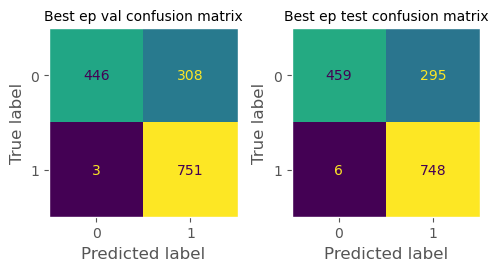

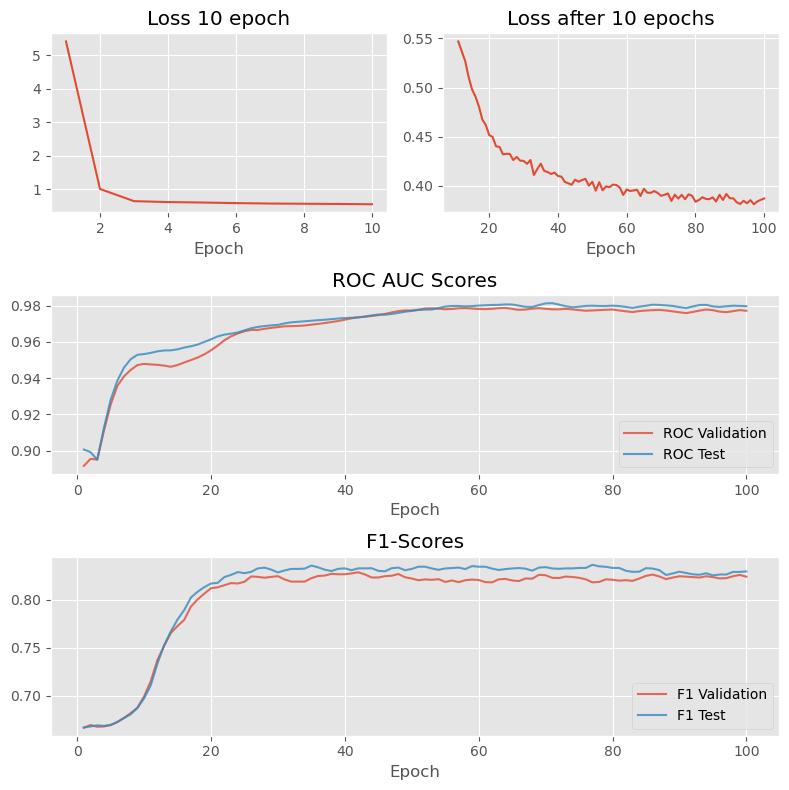

In [46]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=4,
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100) # | AUC Val: 0.924 | AUC Test: 0.894 | F1 Val : 0.685 | F1 Test: 0.695
                            #new embs  AUC Val: 0.974 | AUC Test: 0.974 | F1 Val : 0.828 | F1 Test: 0.832

# Comparison part

Most code and comments are copied from https://github.com/allenai/scidocs/blob/master/scidocs/recomm_click_eval.py

## Upload propensity scores

In [35]:
recomm_path = data_path + 'recomm/'
propensity_score_path = recomm_path + 'propensity_scores.json'

with open(propensity_score_path) as f_in:
    adjClickDistribution = torch.Tensor(json.load(f_in)['scores'])

adjClickDistribution

tensor([0.5929, 0.3906, 0.3019, 0.2665, 0.2509, 0.2073, 0.1840, 0.2287, 0.2125,
        0.2423])

In [36]:
# normalize so that average propensity score is equal to one (to keep loss on similar order as without adj):
adjClickDistribution = adjClickDistribution * len(adjClickDistribution) / (
    sum(adjClickDistribution))
adjClickDistribution

tensor([2.0604, 1.3574, 1.0491, 0.9261, 0.8719, 0.7204, 0.6394, 0.7948, 0.7385,
        0.8420])

I've found what are those propencity scores in the SPECTER paper:
___
As is typical in clickthrough data on ranked lists, the clicks are biased toward the top of original ranking presented to the user. To counteract this effect, we computed `propensity scores` using a swap experiment (Agarwal et al., 2019). The `propensity scores` give, **for each position in the ranked list, the relative frequency that the position is over-represented in the data due to exposure bias.** We can then compute de-biased evaluation metrics by dividing the score for each test example by the propensity score for the clicked position
___

## Upload test or validation data (their metrics were achieved on **test** dataset)

In [37]:
test_data_path = recomm_path + 'test.csv'
val_data_path = recomm_path + 'val.csv'

df_test = pd.read_csv(test_data_path)

df_test.head()

,pid,clicked_pid,similar_papers_avail_at_time
0,70fc27072f024415a812c2d819bfc6b50eefe326,65d3b7df2087134220369ac5c9f4f440ca538d08,"5b2646605d804285176574c5f27f2974e83288e2,fee0c..."
1,f781499f9a2a81dfe50068d32bfe9f36449f1dc6,06c0db75dce988e17e27fb4f2269815c6075e8d8,"562e2a1300e96cf882e17d7dee711d2dedac0580,06c0d..."
2,f8e8f26442a022b2a89b498d7e80701a86ff6691,2268a522cc5a749da38b4e9aaaa6f4239e82ca31,"2268a522cc5a749da38b4e9aaaa6f4239e82ca31,0033a..."
3,92113b42ff8b9a09e45e7292b201e225bc89c379,171444e1456e3136ff4bec661eea5e75464d39b8,"f3fdfc21ff5fb93625a65063f6f32b11d42a3218,17144..."
4,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,90096a59f94b552351ad386db7bee8f1932badc8,"08663b3b57c85d8270acf1931041050d26599c7e,90096..."


`similar_papers_avail_at_time` always have 10 papers inside divided by commas as one string

In [38]:
display(df_test['similar_papers_avail_at_time'])

df_test['similar_papers_avail_at_time'].str.split(',').apply(len).describe()

0      5b2646605d804285176574c5f27f2974e83288e2,fee0c...
1      562e2a1300e96cf882e17d7dee711d2dedac0580,06c0d...
2      2268a522cc5a749da38b4e9aaaa6f4239e82ca31,0033a...
3      f3fdfc21ff5fb93625a65063f6f32b11d42a3218,17144...
4      08663b3b57c85d8270acf1931041050d26599c7e,90096...
                             ...                        
995    2dbe0138ca07dbd9daa3d8d118c1ee2c49620b90,1c2a6...
996    577c4b3ad6ff6324878623c35f47ea4457d415d9,f3372...
997    7e5e5063cba7f4e41c2366eab80c1b2c6aaefa77,a6949...
998    0f31a74ec5cecab2314358bec4457738354bbc76,66f2c...
999    34b4a6ba45efe90c77b245890227cb35c598849e,784e3...
Name: similar_papers_avail_at_time, Length: 1000, dtype: object

count    1000.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: similar_papers_avail_at_time, dtype: float64

### Check the data consistency with our embeddings dataset

Unique values in `val`/`test` dataset

In [39]:
np.unique(
    np.concatenate([
        df_test['pid'].unique(),
        df_test['clicked_pid'].unique(),
        np.concatenate(df_test['similar_papers_avail_at_time'].str.split(','))])
    ).shape


(8758,)

In [40]:
len(set(Grec.nodes))

4716

Intersection of `ids` in both datasets

In [41]:
len(set(np.concatenate([
        df_test['pid'].unique(),
        df_test['clicked_pid'].unique(),
        np.concatenate(df_test['similar_papers_avail_at_time'].str.split(','))
    ])).intersection(set(Grec.nodes)))

1104

Before it was 90, so the situation improved a little

### Filter the dataset to have only available papers 

In [42]:
# Create mask to filter only available papers in 'pid' and 'clicked_pid' cols
mask = (df_test['pid'].isin(Grec.nodes)) & (df_test['clicked_pid'].isin(Grec.nodes))
df_test = df_test[mask]

# Split the 'sim_papers' col and leave values that are available in the Graph
df_test['similar_papers_avail_at_time'] = df_test['similar_papers_avail_at_time'].str.split(',')
df_test['similar_papers_avail_at_time'] = df_test['similar_papers_avail_at_time'].apply(
                                        lambda ls: [paper for paper in ls if paper in Grec.nodes]
                                        )

# Get rid of rows with less then 2 values (comparison won't make sence)
df_test = df_test[df_test['similar_papers_avail_at_time'].apply(len) > 1]
df_test['similar_papers_avail_at_time'] = df_test['similar_papers_avail_at_time'].apply(lambda lst: ','.join(lst))
display(df_test)

# Upload filtered dataset
test_filtered_data_path = recomm_path + 'test_filtered.csv'
df_test.to_csv(test_filtered_data_path, index=False)

,pid,clicked_pid,similar_papers_avail_at_time
4,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,90096a59f94b552351ad386db7bee8f1932badc8,"90096a59f94b552351ad386db7bee8f1932badc8,821fd..."
6,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,821fd5bed14d6d06c25fbf44123fd7be382f7b4e,"90096a59f94b552351ad386db7bee8f1932badc8,821fd..."
14,6dae703128d9caff2623eb8dfe2526dc6ad7aff5,4a63437aaee3267a5b427588adecb1c73a95b423,"4a63437aaee3267a5b427588adecb1c73a95b423,0ce54..."
17,cb40a5e6d4fc0290452345791bb91040aed76961,c6a9ca56c93323c0199dd22631d1cf731bdd7ec1,"8fd1d13e18c5ef8b57296adab6543cb810c36d81,5772b..."
18,3d9d1c26a8dc82ca54154d6f2304507ce65bcb35,fc7d91dbb549a5c834d663944670bf4f08bc9b00,"7874c01633ca800b6e38b188dd0b1cbf6f3f9ece,0dc6f..."
...,...,...,...
935,1e56ed3d2c855f848ffd91baa90f661772a279e1,3d74d241af53d85cbc74f73a785fddd675f0e644,"3d74d241af53d85cbc74f73a785fddd675f0e644,9e6f3..."
937,cf755dd097b7286e8e53ba637c495229f2587e84,1b49a3b9a44c5213a03129faba81cccc75a4d5ff,"1b49a3b9a44c5213a03129faba81cccc75a4d5ff,b946c..."
948,9a6a8cbb10b719cdb565ca9be01c7bf4df049bf0,560d3334047c0455951a4a672941103bf49c1f40,"3e5655307333589f52f2aab8678f3e1c9184a88f,b77b4..."
985,a217e85ca33c46ebb06812fdd30f133a83cd0890,3b3291e1f908f583a478e15fb40bffb6dd26cf14,"3b3291e1f908f583a478e15fb40bffb6dd26cf14,ad66b..."


### Open the `csv` as it was in original code

In [43]:
with open(test_filtered_data_path, 'r') as f_in:
    clicks = f_in.read().splitlines()

print(f"Clicks variable contain {len(clicks[1:])} examples with columns:")

for i, cl in enumerate(clicks[0].split(',')):
    print(f'{i+1}.{cl}')

clicks = clicks[1:]

Clicks variable contain 71 examples with columns:
1.pid
2.clicked_pid
3.similar_papers_avail_at_time


## Comparison for-loop (work in progress)

In [44]:
#sp2_embs = pd.read_json('papers_embeddings_sp2.json')
sp2_embs = {}
with open('papers_embeddings_sp2.json', 'r') as f:
    all_sp2_embs = json.load(f)
    for id, emb in tqdm(all_sp2_embs.items(), desc='reading embeddings from file...'):
        if id in Grec.nodes:
            sp2_embs[id] = np.array(emb, dtype=np.float32)
    del all_sp2_embs


reading embeddings from file...: 100%|██████████| 4716/4716 [00:00<00:00, 16254.41it/s]


In [54]:
gnn = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=3,
                            sz_hid=256,
                            sz_out=128)
print(gnn)
data = train_val_test_split(Grec, 0,0)
H = train(gnn, data, num_epochs=100, test=False)  # new embs AUC Val: 0.977 | AUC Test: 0.976 | F1 Val : 0.823 | F1 Test: 0.825
                                

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 128)
  )
)


Function for finding euclidean distance on SPECTER 2 embeddings

In [64]:
from scipy.spatial.distance import euclidean

def find_L2_distance_SPECTER2(embs, query_paper_id, comp_paper_id):
    """
    Computes the negative L2 (Euclidean) distance between the embeddings of two papers,
    effectively turning the distance metric into a similarity metric where larger values indicate closer or more similar papers.

    Parameters:
      embs (dict): the embeddings dictionary containing 'id': 'embedding_vector' pairs
      query_paper_id (str): The identifier for the query paper. This ID should correspond to a key in the `sp2_embs` dictionary.
      comp_paper_id (str): The identifier for the comparison paper. This ID should also correspond to a key in the `sp2_embs` dictionary.

    Returns:
      float: The negative L2 distance between the embeddings of the query paper and the comparison paper.
    
    """

    # Retrieve the embeddings for the query and comparison papers from the pre-loaded embeddings dictionary
    query_emb = embs[query_paper_id]
    comp_emb = embs[comp_paper_id]

    # Compute the Euclidean (L2) distance between the two embeddings
    dist = euclidean(query_emb, comp_emb)

    # Return the negative distance to convert the distance metric into a similarity metric
    # A larger (less negative) value indicates a smaller distance or higher similarity
    return -dist


Function for receiving dot-product between two paper nodes in GNN (in progress)

In [61]:
def get_dot_prod_GNN(H, G, query_paper, comp_paper):
    """
    Computes the dot product similarity between two nodes (papers) in a graph using a trained GNN.

    Parameters:
      H (Tensor): The node embeddings matrix produced by the GNN, where each row corresponds to a node's embedding.
      query_paper (str): The id of the query paper node in the graph.
      comp_paper (str): The id of the comparison paper node in the graph.

    Returns:
      dot_prod_res (Tensor): The dot product result representing the similarity between the query paper and the comparison paper.
    """

    # Convert the graph nodes into a list to work with indices
    nodes_list = list(G.nodes())  # Assuming Grec is a pre-defined graph variable

    # Find the indices of the query and comparison papers in the nodes list
    query_and_comp_edge_ind = ([nodes_list.index(query_paper)], [nodes_list.index(comp_paper)])

    # Use the GNN's decode method to compute the dot product similarity between the embeddings of the two papers
    dot_prod_res = gnn.decode(H, query_and_comp_edge_ind)

    return dot_prod_res

RankMetricsCalculator class to calculate all metrics related stuff and improve the structure

In [48]:
class RankMetricsCalculator:
    """
    A class to calculate various ranking metrics including accuracy, normalized discounted cumulative gain (NDCG),
    mean reciprocal rank (MRR), and precision at rank 1 (Rprec/P@1), along with their adjusted versions.
    """

    def __init__(self):
        # Counts of items ranked in correct and incorrect order
        self.correct_order = 0
        self.incorrect_order = 0

        # Accumulators for metrics
        self.mrr = 0
        self.ndcg_numerator = 0
        self.rprec = 0

        # Adjusted metrics accumulators
        self.adj_demonimator = 0
        self.adj_ndcg_numerator = 0
        self.adj_correct_order = 0
        self.adj_incorrect_order = 0
        self.adj_mrr = 0
        self.adj_rprec = 0

    def calculate_metrics(self, neg_scores, pos_score, adj):
        """
        Calculates and updates ranking metrics based on the scores of negative (incorrect) and positive (correct) instances,
        and an adjustment factor for adjusted metrics.

        Parameters:
          neg_scores (list of float): Scores of negative instances.
          pos_score (float): Score of the positive instance.
          adj (float): Adjustment factor for calculating adjusted metrics.
        """
        # Count how many negative scores are ranked above and below the positive score
        ranked_above = sum(1 for x in neg_scores if x > pos_score)
        ranked_below = sum(1 for x in neg_scores if x < pos_score)

        # Handle ties by assigning half a point to both above and below for each tie
        ranked_above += sum(0.5 for x in neg_scores if x == pos_score)
        ranked_below += sum(0.5 for x in neg_scores if x == pos_score)

        # Update counts of correct and incorrect orders
        self.correct_order += ranked_below
        self.incorrect_order += ranked_above
        
        # Calculate and update metrics
        ndcg = 1 / np.log2(2 + ranked_above)  # NDCG calculation for the current instance
        self.mrr += 1 / (1 + ranked_above)  # MRR update
        self.ndcg_numerator += ndcg  # NDCG numerator update
        self.rprec += 1 if ranked_above == 0 else 0  # Rprec/P@1 update
        
        # Calculate and update adjusted metrics using the adjustment factor
        self.adj_demonimator += adj
        self.adj_ndcg_numerator += adj * ndcg
        self.adj_correct_order += adj * ranked_below
        self.adj_incorrect_order += adj * ranked_above
        self.adj_mrr += adj * (1 / (1 + ranked_above))
        self.adj_rprec += adj * (1 if ranked_above == 0 else 0)

    def get_results(self, clicks):
        """
        Calculates and returns the final metrics based on the accumulated values and the number of clicks (instances).

        Parameters:
          clicks (list): The list of clicks or instances considered for the metrics calculation.

        Returns:
          metrics (dict): A dictionary containing the calculated metrics.
        """
        metrics = {
            "accuracy": self.correct_order / (self.correct_order + self.incorrect_order),
            "ndcg": self.ndcg_numerator / len(clicks),
            "mrr": self.mrr / len(clicks),
            "Rprec/P@1": self.rprec / len(clicks),
            "Adj-accuracy": self.adj_correct_order / (self.adj_incorrect_order + self.adj_correct_order),
            "Adj-ndcg": self.adj_ndcg_numerator / self.adj_demonimator,
            "Adj-mrr": self.adj_mrr / self.adj_demonimator,
            "Adj-Rprec/P@1": self.adj_rprec / self.adj_demonimator
        }
        return metrics


In [66]:
metrics_calculator_specter = RankMetricsCalculator()
metrics_calculator_gnn = RankMetricsCalculator()

for line in tqdm(clicks):
        # Prepare ids from file
        [query_id, clicked_id, other_id_str] = list(csv.reader([line], delimiter=',', quotechar='"'))[0]
        other_ids = other_id_str.strip().split(",")
        position = 1
        paper_score_specter = [] #used for output
        paper_score_gnn = [] #used for output

        # Find positive query-recom scores
        clicked_position = other_ids.index(clicked_id) + 1
        pos_score_specter = find_L2_distance_SPECTER2(sp2_embs, query_id, clicked_id)
        pos_score_gnn = get_dot_prod_GNN(H, Grec, query_id, clicked_id)
        paper_score_specter.append([clicked_id, pos_score_specter])
        paper_score_gnn.append([clicked_id, pos_score_gnn])

        # Find negative query-recom scores
        neg_scores_specter = []
        neg_scores_gnn = []
        adj = 1 / adjClickDistribution[clicked_position-1]
        for other_id in other_ids:
            if not other_id == clicked_id:
                neg_score_specter = find_L2_distance_SPECTER2(sp2_embs, query_id, other_id)
                neg_score_gnn = get_dot_prod_GNN(H, Grec, query_id, other_id)
                neg_scores_specter.append(neg_score_specter)
                neg_scores_gnn.append(neg_score_gnn)
                paper_score_specter.append([other_id, neg_score_specter])
                paper_score_gnn.append([other_id, neg_score_gnn])
            position = position + 1
        
        metrics_calculator_specter.calculate_metrics(neg_scores_specter, pos_score_specter, adj)
        metrics_calculator_gnn.calculate_metrics(neg_score_gnn, pos_score_gnn, adj)

metrics_specter = metrics_calculator_specter.get_results(clicks)
metrics_gnn = metrics_calculator_gnn.get_results(clicks)

display('SPECTER 2:', metrics_specter,
      'GNN', metrics_gnn)

100%|██████████| 71/71 [00:00<00:00, 611.93it/s]


'SPECTER 2:'

{'accuracy': 0.6658291457286433,
 'ndcg': 0.6408412230074018,
 'mrr': 0.5243125419181757,
 'Rprec/P@1': 0.2676056338028169,
 'Adj-accuracy': tensor(0.6588),
 'Adj-ndcg': tensor(0.6113),
 'Adj-mrr': tensor(0.4861),
 'Adj-Rprec/P@1': tensor(0.2285)}

'GNN'

{'accuracy': 0.5985915492957746,
 'ndcg': 0.8510211816530542,
 'mrr': 0.7981220657276995,
 'Rprec/P@1': 0.5915492957746479,
 'Adj-accuracy': tensor(0.6052),
 'Adj-ndcg': tensor(0.8538),
 'Adj-mrr': tensor(0.8019),
 'Adj-Rprec/P@1': tensor(0.6010)}

In [59]:
# SPECTER-2
# {'accuracy': 0.6658291457286433,
#  'ndcg': 0.6408412230074018,
#  'mrr': 0.5243125419181757,
#  'Rprec/P@1': 0.2676056338028169,
#  'Adj-accuracy': tensor(0.6588),
#  'Adj-ndcg': tensor(0.6113),
#  'Adj-mrr': tensor(0.4861),
#  'Adj-Rprec/P@1': tensor(0.2285)}

# SPECTER
# {'accuracy': 0.6256281407035176,
#  'ndcg': 0.6118552846993199,
#  'mrr': 0.4871450927788954,
#  'Rprec/P@1': 0.23943661971830985,
#  'Adj-accuracy': tensor(0.6344),
#  'Adj-ndcg': tensor(0.5911),
#  'Adj-mrr': tensor(0.4601),
#  'Adj-Rprec/P@1': tensor(0.2075)}

# GNN (NEW result)
# {'accuracy': 0.5985915492957746,
#  'ndcg': 0.8510211816530542,
#  'mrr': 0.7981220657276995,
#  'Rprec/P@1': 0.5915492957746479,
#  'Adj-accuracy': tensor(0.6052),
#  'Adj-ndcg': tensor(0.8538),
#  'Adj-mrr': tensor(0.8019),
#  'Adj-Rprec/P@1': tensor(0.6010)}

# GNN (OLD result)
# {'accuracy': 0.5841708542713567,
#  'ndcg': 0.6051892136642196,
#  'mrr': 0.4803330081499094,
#  'Rprec/P@1': 0.23943661971830985,
#  'Adj-accuracy': tensor(0.5528),
#  'Adj-ndcg': tensor(0.5593),
#  'Adj-mrr': tensor(0.4214),
#  'Adj-Rprec/P@1': tensor(0.1808)}